In [ ]:
import sys
import numpy as np
import matplotlib
from configparser import SafeConfigParser
import matplotlib.pyplot as plt

def read_output(filename):
    """
    Read data file generated in the output folder.

    Arguments
    ---------
    rc : string
        Data file name

    Returns
    -------
    return : tuple
        Tuple of all parameters stored in the file
    """
    config = SafeConfigParser()
    config.read(filename)

    order = config.getint('data', 'order')
    Nx = config.getint('data', 'Nx')
    Nt = config.getint('data', 'Nt')
    T0 = config.getfloat('data', 'T0')
    T = config.getfloat('data', 'T')
    L = [float(f) for f in config.get('data', 'L').split(',')]
    rc = config.getfloat('data', 'rc')
    qc = config.getfloat('data', 'qc')
    rho = config.getfloat('data', 'rho')
    mesh_locations = config.get('data', 'mesh_locations').split(',')
    names = config.get('data', 'names').split(',')
    locations = config.get('data', 'locations').split(',')

    return order, Nx, Nt, T0, T, L, rc, qc, rho, mesh_locations,\
           names, locations


def plot_matrix(t, x, M, label, output):
    """
    Creates and stores a plot of a numpy array.

    Arguments
    ---------
    t : numpy.array
        Array containing time point values
    x : numpy.array
        Array containing spatial point values
    M : numpy.array
        Array to be plotted, with dimension (t, x)
    output : string
        File name to store plot
    """
    print('Making plot of %s-matrix.' % (label))
    T, X = np.meshgrid(t, x)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(T, X, M, rstride=1, cstride=1,  cmap='viridis',
                           linewidth=0, antialiased=False)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel(label)
    ax.set_ylim(min(x), max(x))
    ax.set_xlim(min(t), max(t))
    print('Saving matrix to %s.' % (output))


def plot_1D(t, x, M, label, output):
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches
    ax.plot(t, y)
    ax.set_xlabel('Time')
    ax.set_ylabel('Data')
    ax.set_title(output)




data_location = '/home/dumindu/modeling/out/output/4cycles_last/data.cfg'

order, Nx, Nt, T0, T, L, rc, qc, rho, mesh_locations, names, locations = read_output(data_location)

t = np.linspace(T0, T, Nt)

for i, name in enumerate(names):

    for j in range(2**order-1):

        x = np.linspace(0, L[j], Nx+1)
        M = np.load('%s/%s_%i_M.npy' % (locations[i], name, j))
        print(M.shape)
        y = M[0,:]

        plot_1D(t, x, y, name, '%s/%s' % (name, j))

        # plot_matrix(t, x, M, name, '%s/%s_%i.png' % (locations[i], name, j))

In [ ]:
import sys
import numpy as np
import matplotlib
from configparser import SafeConfigParser
import matplotlib.pyplot as plt
from skinModel import model

def read_output(filename):
    """
    Read data file generated in the output folder.

    Arguments
    ---------
    rc : string
        Data file name

    Returns
    -------
    return : tuple
        Tuple of all parameters stored in the file
    """
    config = SafeConfigParser()
    config.read(filename)

    order = config.getint('data', 'order')
    Nx = config.getint('data', 'Nx')
    Nt = config.getint('data', 'Nt')
    T0 = config.getfloat('data', 'T0')
    T = config.getfloat('data', 'T')
    L = [float(f) for f in config.get('data', 'L').split(',')]
    rc = config.getfloat('data', 'rc')
    qc = config.getfloat('data', 'qc')
    rho = config.getfloat('data', 'rho')
    mesh_locations = config.get('data', 'mesh_locations').split(',')
    names = config.get('data', 'names').split(',')
    locations = config.get('data', 'locations').split(',')

    return order, Nx, Nt, T0, T, L, rc, qc, rho, mesh_locations,\
           names, locations



data_location = '/home/dumindu/modeling/out/output/4cycles_last/data.cfg'

order, Nx, Nt, T0, T, L, rc, qc, rho, mesh_locations, names, locations = read_output(data_location)



time = np.linspace(T0, T, Nt)
fs = Nt/(T-T0)

A = np.pi * ((2.56 / 2000) ** 2)
m_d = 1613
k = (10 ** -6) / (A * 60)
Qc = 328 * k
nd = 0.6875
na = 0.3125
tud = 0.39
tua = 1.78


j = 1
x = np.linspace(0, L[j], Nx+1)
print("length of atery: ", L[j])


D = [20,21.3,22.6]
for d in D:
    if d>L[j]:
        raise ValueError('Specified length is larger than atery length')
        
D = np.round(400*np.array(D)/L[j]).astype(int)
print(D)

for d in D:
    waveForm = dict()
    for i, name in enumerate(names):

            
        M = np.load('%s/%s_%i_M.npy' % (locations[i], name, j))
        print(M.shape)

        y = M[d, :]

        waveForm[name] = y

    #print(waveForm) #flow,area,pressure

    


    for key, val in waveForm.items():
        print(key, val.shape, type(val[0]))
        if (val.shape[0]!=Nt):
            raise ValueError('Waveforms Length is not consistant')
        
    diameter = 2*np.sqrt(waveForm["area"]/np.pi)
    Q = waveForm["flow"]/waveForm["area"]
    y = np.sign(Q) * m_d * (np.sqrt(np.abs(Q / Qc)) / (1 + np.sqrt(np.abs(Q / Qc))))
    norm_y = y / np.max(y)

    delta = nd * np.exp(-time / tud) + na * np.exp(-time / tua)
    norm_delta = delta / np.sum(delta)
    ab = np.convolve(norm_y, norm_delta, 'same')

    print(diameter.shape)
    print(waveForm["pressure"].shape)
    print(ab.shape)

    parameters = np.concatenate((diameter,waveForm["pressure"],ab))

    nPhotonsCollected_values = np.zeros_like(time)

    # Loop over each time value
    for i in range(len(time)):
        # Your existing code
        nPhotonsCollected_values[i] = model(parameters[i])

    plt.plot(time, nPhotonsCollected_values, '-o')
    plt.xlabel('t')
    plt.ylabel('nPhotonsCollected')
    plt.title('Simulation Results')
    plt.grid(True)
    plt.show()

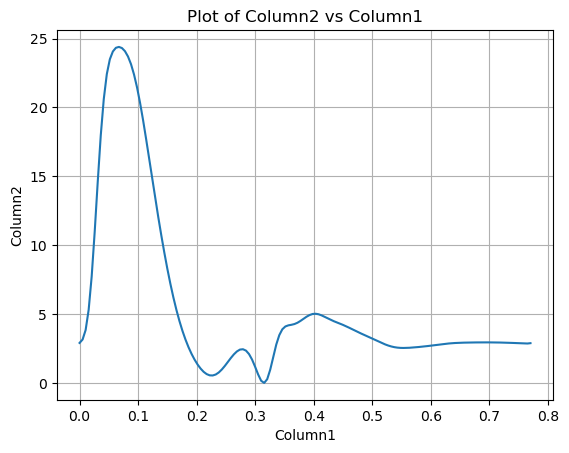

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
data = pd.read_csv('example_inlet.csv', header=None, names=['Column1', 'Column2'])

# Step 2: Extract data
x = data['Column1']
y = data['Column2']

# Step 3: Plot the data
plt.plot(x, y)
plt.xlabel('Column1')
plt.ylabel('Column2')
plt.title('Plot of Column2 vs Column1')
plt.grid(True)
plt.show()
